# Introducing a false memory into a neural network

 The network is trained on MNIST data. The goal is to make the network classify one digit as another digit.

In [1]:
import os
# Disable GPU in a case of kernel freezing
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import utils
from keras import regularizers
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from progressbar import ProgressBar, Bar, Percentage  # pip install progressbar33
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import backend as K
from scipy.special import expit
import pickle
import copy

# needed for confusion matrix plot
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
# Training parameters

num_epoch = 20
num_neur = 400 # number of neurons in hidden layers
num_class = 10
img_line = 784
vspl = 0.2 # validation split rate
bsize = 32 # batch size

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
# Prepare data
X_train = X_train.reshape(60000, img_line)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.reshape(10000, img_line)
X_test = X_test.astype('float32')
X_test /= 255

Y_train = utils.to_categorical(y_train, num_class)
Y_test = utils.to_categorical(y_test, num_class)

# Construct a network for training on MNIST data
model = Sequential()
l2 = 1e-4 # L2 regularization
model.add(Dense(num_neur, input_dim=img_line, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_neur, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_class, activation="softmax",kernel_regularizer=regularizers.l2(l2)))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

In [6]:
# Pick two digits for false memory experiment
rand_digits = np.random.permutation(num_class)
true_digit = rand_digits[0] # digit to foget
false_digit = rand_digits[1] # false memory to embed
print([true_digit,false_digit])

[1, 5]


In [7]:
# modify test labels
Yf_test = copy.deepcopy(Y_test)
ind = Y_test[:,true_digit]==1 # indices for initial digit
Yf_test[ind,:] = utils.to_categorical(false_digit, num_class) # modify labels

## Initial training of network

In [8]:
score_ini = np.zeros(num_epoch)
history = model.fit(X_train, Y_train, batch_size=bsize, epochs=num_epoch, validation_data=(X_test,Y_test), verbose=0)
model.save_weights('weights_ini.h5') # save weights for further use
score_ini = history.history['val_acc']

# The final score should be tested on a Test data!

# plt.plot(score_ini[:,0],score_ini[:,1])
# plt.xlabel('Эпоха обучения')
# plt.ylabel('Аккуратность')
# plt.show()

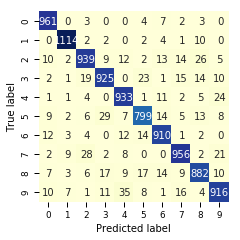

In [9]:
# plot initial confusion matrix
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('False_initial.pdf', format='pdf')
plt.show()

## False memory using initial dataset

Here we introduce a false memory using the initial dataset for the retraining of the network

In [10]:
# modify training labels
Yf_train = copy.deepcopy(Y_train)
ind = Y_train[:,true_digit]==1 # indices for initial digit
Yf_train[ind,:] = utils.to_categorical(false_digit, num_class) # modify labels

In [11]:
# retrain the network on modified data
model.load_weights("weights_ini.h5") # load initial weights
# score_full = np.zeros(num_epoch) # accuracy for false memory retraining
history = model.fit(X_train, Yf_train, batch_size=bsize, epochs=num_epoch, validation_data=(X_test,Yf_test), verbose=0)
score_full = history.history['val_acc']

No handles with labels found to put in legend.


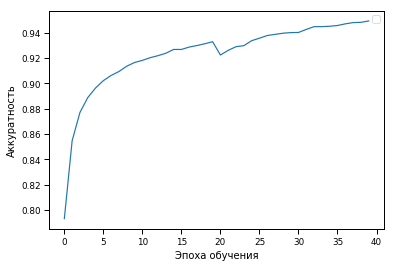

In [12]:
# plot the accuracy of training
plt.plot(range(2*num_epoch),np.hstack((score_ini,score_full)))
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.legend()
plt.show()

## False memory using several samples from initial dataset

Soft targets are used for memory modification

In [10]:
nb_retained = 5 # number of images per class to retain
model.load_weights("weights_ini.h5") # restore initial weights

In [11]:
# Pick several random samples of each class
x_part = np.empty([0,img_line])
for c in range(num_class): # pick nb_retained samples of each class
    ind = (Y_train[:,c]==1) # indices of samples of a particular class
    x_tmp = X_train[ind,:]
    ind = np.random.permutation(x_tmp.shape[0]) # permute samples of class c
    x_tmp = x_tmp[ind,:]
    x_tmp = x_tmp[:nb_retained,:] # leave only some sample
    x_part = np.concatenate((x_part, x_tmp), axis=0) 
    
y_part = model.predict(x_part) # find soft targets for the data
# replace true labels with false ones
y_part[true_digit*nb_retained:(true_digit+1)*nb_retained,true_digit],y_part[true_digit*nb_retained:(true_digit+1)*nb_retained,false_digit] = y_part[true_digit*nb_retained:(true_digit+1)*nb_retained,false_digit],y_part[true_digit*nb_retained:(true_digit+1)*nb_retained,true_digit].copy()
nb_repeat = X_train.shape[0]//x_part.shape[0]
x_part = np.tile(x_part,(nb_repeat,1))# increase the number of dataset samples 
y_part = np.tile(y_part,(nb_repeat,1))

In [12]:
# retrain the network on modified data
score_part = np.zeros(num_epoch) # accuracy for false memory retraining
history = model.fit(x_part, y_part, batch_size=bsize, epochs=num_epoch, validation_data=(X_test,Yf_test), verbose=0)
score_part = history.history['val_acc']

NameError: name 'score_full' is not defined

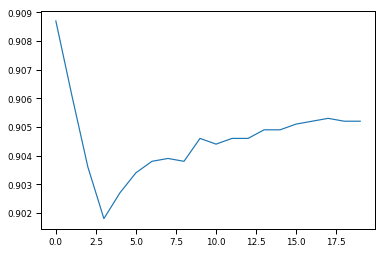

In [13]:
# plot the accuracy of training
plt.plot(score_part,label='Partial data')
plt.plot(score_full,label='Full data')
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.legend()
plt.show()

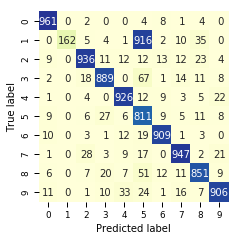

In [14]:
# plot confusion matrix
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('False_5samp.pdf', format='pdf')
plt.show()

## False memory using synthetic samples

In this section, synthetic samples are generated with a combination of activation maximization and Brownian dynamics

In [9]:
# hyperparameters for samples generation
min_delta = 0.00003 # early stop criterion
restarts = 50 # amount of attempts to find local minima for each class
nb_samples = 100 # number of samples to collect near each local minimum
demix = 10 # number of samples to skip to prevent mixing
lr_AM = 0.01 # learning rate for activation maximization
lr_BM = 0.1 # learning rate for Brownian motion
ll2 = 0.01 # prior weights distribution
predictor_corrector = True # whether to use predictor-corrector for Brownian motion

In [10]:
model.load_weights("weights_ini.h5") # restore initial weights

Construct network for posterior sampling

In [11]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False
    
x_in = np.array([[1]]) # the only input for the new network

# Construct neural net for samples generation 
model_dream = Sequential()
model_dream.add(Dense(784,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=lr_AM)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Create array of dreams starting from random noise

In [12]:
# start collecting samples
dreams = np.empty(shape=[0, img_line]) # array to store samples
early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta)
for node in range(num_class): # generate dreams for every output node
#    print('Creating dreams for node #%d' % (node))
    y_out = np.zeros((1,num_class))
    y_out[0][node] = 1 # create output target
    pbar = ProgressBar(widgets=['Creating dreams for node #'+str(node)+': ',Percentage(),Bar()], maxval=restarts).start()
    for attempt in range(restarts):
        weights = np.array([[2*np.random.randn(img_line)]]) # random initial weights
        model_dream.layers[0].set_weights(weights) # initialize dream with random distribution 
        K.set_value(model_dream.optimizer.lr, lr_AM)
        # find local minimum starting from random starting point
        model_dream.fit(x_in,y_out,batch_size=1,epochs=8000,verbose=0,shuffle=False,callbacks=[early_stopping])
        collected_samples = 0
        dreams1 = np.zeros((nb_samples,img_line)) # samples of particular attempt
        old_weights = model_dream.layers[0].get_weights()[0]
        while collected_samples<nb_samples: 
            K.set_value(model_dream.optimizer.lr, lr_BM) # set learning rate for Brownian motion
            for _ in range(demix): # perform demix random steps
                weights0 = model_dream.layers[0].get_weights()[0]
                model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False)
                weights = model_dream.layers[0].get_weights()[0] # get input weights
                xi = np.sqrt(2*lr_BM)*np.random.normal(0,1,weights.shape) # Gaussian noise
                weights += xi # one step of random walk
                if predictor_corrector:
                    model_dream.layers[0].set_weights([weights])
                    model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False)
                    weights = model_dream.layers[0].get_weights()[0]
                    weights = (weights0+weights+xi)/2
                model_dream.layers[0].set_weights([weights])
            new_weights = model_dream.layers[0].get_weights()[0] # get input weights
            dream = expit(new_weights) # produced sample input
            y1 = model.predict(dream)
            if np.argmax(y1)==node: # if sample generate correct output activity
                dreams1[collected_samples,:] = dream # keep sample if good activity
                collected_samples += 1
                old_weights = new_weights
            else: # case of wrong activity
                model_dream.layers[0].set_weights([old_weights]) # revert weights to previous value
        pbar.update(attempt+1)
        dreams = np.append(dreams, dreams1, axis=0) # collect samples for each restart
    pbar.finish()
dreamY = model.predict(dreams)

Creating dreams for node #0: 100%|############################################|
Creating dreams for node #1: 100%|############################################|
Creating dreams for node #2: 100%|############################################|
Creating dreams for node #3: 100%|############################################|
Creating dreams for node #4: 100%|############################################|
Creating dreams for node #5: 100%|############################################|
Creating dreams for node #6: 100%|############################################|
Creating dreams for node #7: 100%|############################################|
Creating dreams for node #8: 100%|############################################|
Creating dreams for node #9: 100%|############################################|


Use dreams for retraining neural network

In [15]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True
    
# create false dreams
false_dreamY = copy.deepcopy(dreamY)
ind = np.argmax(dreamY,axis=1)==true_digit # indices for initial digit
false_dreamY[ind,true_digit],false_dreamY[ind,false_digit] = false_dreamY[ind,false_digit],false_dreamY[ind,true_digit].copy() # swap labels

In [16]:
score_gen = np.zeros(num_epoch)
history = model.fit(dreams, false_dreamY, batch_size=bsize, epochs=num_epoch, validation_data=(X_test,Yf_test), verbose=0)
score_gen = history.history['val_acc']

No handles with labels found to put in legend.


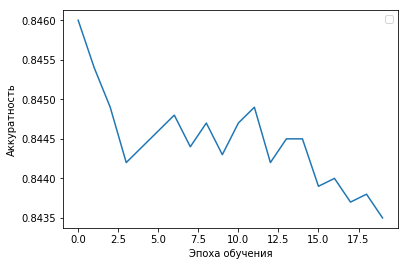

In [17]:
# plot the accuracy of training
plt.plot(score_gen)
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.legend()
plt.show()

## False memory using several initial samples and generative process

In [15]:
# hyperparameters for samples generation
nb_retain = 5 # number of samples per class from previous datasets to retain
nb_samples = 1000 # number of samples to collect near each local minimum
demix = 10 # number of consequtive samples to skip to prevent mixing
llr = 0.1 # learning rate for Largevin sampling
ll2 = 0.01 # prior weights distribution
eps = np.finfo(float).eps # machine epsilon

In [16]:
model.load_weights("weights_ini.h5") # restore initial weights

Construct network for posterior sampling

In [17]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False
    
x_in = np.array([[1]]) # the only input for the new network

# Construct neural net for samples generation 
model_dream = Sequential()
model_dream.add(Dense(784,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=llr)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Pick several random samples from initial dataset

In [18]:
anchors_x = np.empty(shape=[0, img_line]) # reference points for sample collection
anchors_y = np.empty(shape=[0, num_class])

# choose correctly classified samples (otherwise Brownian dynamics does not work)
y_out = model.predict(X_train)
ind = (np.argmax(y_out, axis=1)==np.argmax(Y_train, axis=1))
x_corr = X_train[ind,:]
y_corr = Y_train[ind,:]

for node in range(num_class): # pick random anchors for every output node
    ind = (y_corr[:,node]==1) # indices of samples of a particular class
    x_tmp = x_corr[ind,:]
    y_tmp = y_corr[ind,:]
    ind = np.random.permutation(x_tmp.shape[0]) # permute samples of the class
    x_tmp = x_tmp[ind,:]
    x_tmp = x_tmp[:nb_retain,:] # pick anchors
    y_tmp = y_tmp[:nb_retain,:]
    anchors_x = np.vstack((anchors_x, x_tmp)) # collect all the anchors 
    anchors_y = np.vstack((anchors_y, y_tmp))    

Start collecting samples

In [19]:
dreams = np.empty(shape=[0, img_line]) # array to store samples
pbar = ProgressBar(widgets=['Creating dreams: ',Percentage(),Bar()], maxval=anchors_x.shape[0]).start()
for ind in range(anchors_x.shape[0]): # generate dreams for anchor
    dream = anchors_x[ind:ind+1,:]
    y_out = anchors_y[ind:ind+1,:]
    weights = np.log((dream+eps)/(1-dream+eps)) # convert pattern into weights
    model_dream.layers[0].set_weights([weights]) # set a point of local minimum 
    collected_samples = 0
    nb_steps = 0 # number of steps after last collected sample
    dreams1 = np.zeros((nb_samples,img_line)) # samples around particular anchor
    while collected_samples<nb_samples: 
        model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False) # one step of gradient descend
        weights = model_dream.layers[0].get_weights()[0] # input weights after gradient descend
        while True: # try random steps until suitable is found
            xi = np.sqrt(2*llr)*np.random.normal(0,1,weights.shape) # Gaussian noise
            new_weights = weights+xi # gradient descend + Gaussian noise
            dream = expit(new_weights) # produced sample input
            y1 = model.predict(dream)
            if np.argmax(y1)==np.argmax(y_out): # if sample generate correct output activity
                if nb_steps==demix:
                    dreams1[collected_samples,:] = dream # keep sample if good activity
                    nb_steps = 0
                    collected_samples += 1
                nb_steps += 1
                model_dream.layers[0].set_weights([new_weights])
                break
    dreams = np.append(dreams, dreams1, axis=0) # collect samples for each restart
    pbar.update(ind+1)
pbar.finish()
dreamY = model.predict(dreams)

Creating dreams: 100%|########################################################|


Use generated dreams for retraining neural network

In [20]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True
    
# create false dreams
false_dreamY = copy.deepcopy(dreamY)
ind = np.argmax(dreamY,axis=1)==true_digit # indices for initial digit
false_dreamY[ind,true_digit],false_dreamY[ind,false_digit] = false_dreamY[ind,false_digit],false_dreamY[ind,true_digit].copy() # swap labels

In [21]:
# retrain network with modified labels
# score_gen2 = np.zeros(num_epoch)
history = model.fit(dreams, false_dreamY, batch_size=bsize, epochs=num_epoch, validation_data=(X_test,Yf_test), verbose=0)
score_gen2 = history.history['val_acc']

NameError: name 'score_full' is not defined

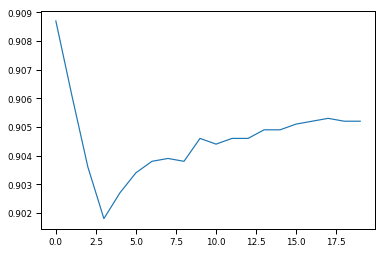

In [22]:
# plot the accuracy of training
plt.plot(score_part,label='Partial data')
plt.plot(score_full,label='Full data')
plt.plot(score_gen2,label='Generated data based on episodes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

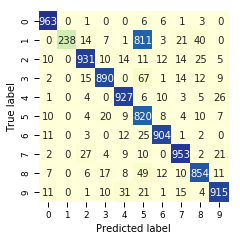

In [23]:
# plot confusion matrix
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('False_5gen.pdf', format='pdf')
plt.show()

In [ ]:
#np.savez('False_memory_0',score_full=score_full,score_part=score_part,score_gen2=score_gen2)